In [22]:
### Library Imports
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")


In [23]:
### Import Stock Data
def get_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start_date, end_date)['Adj Close']
        # Reset Headers to be in the same row
        data.reset_index(inplace = True)
    
    return data

### Return Stock Data
tickers = ['AAPL']  # Ticker symbol for the S&P 500
start_date = '1990-01-01'
end_date = '2024-01-01'
stock_data = get_data(tickers, start_date, end_date)
print(stock_data.tail())

# Get most recent stock price
s_0 = stock_data['AAPL'].iloc[-1]
print('The most recent stock price is: ', round(s_0, 4))


[*********************100%%**********************]  1 of 1 completed

           Date        AAPL
8560 2023-12-22  192.868134
8561 2023-12-26  192.320221
8562 2023-12-27  192.419830
8563 2023-12-28  192.848221
8564 2023-12-29  191.802185
The most recent stock price is:  191.8022


In [24]:
### Calculate Log Returns
def compute_metrics(data, window):
    # Drop Date Column
    data = data.drop(columns = ['Date'])
    
    # Calculate Log Returns and store in a seperate col
    data['Log Returns'] = np.log(data / data.shift(1))
    data = data.dropna()  # Remove any NaN values

    # Calculate Voltility - rolling stddev of log returns
    data['Volatility'] = data['Log Returns'].rolling(window = window).std()

    return data

stock_data_full = compute_metrics(stock_data, window = 30)
print(stock_data_full)


            AAPL  Log Returns  Volatility
1       0.264179     0.006689         NaN
2       0.265060     0.003331         NaN
3       0.265941     0.003316         NaN
4       0.267702     0.006601         NaN
5       0.265060    -0.009917         NaN
...          ...          ...         ...
8560  192.868134    -0.005563    0.009297
8561  192.320221    -0.002845    0.008449
8562  192.419830     0.000518    0.008246
8563  192.848221     0.002224    0.007892
8564  191.802185    -0.005439    0.007970

[8564 rows x 3 columns]


In [66]:
### Determine Regime States and Populate Column
def three_state_volatility(data):
    # Define high and low thresholds using quantiles (mid_thresh is remaining)
    low_thresh = stock_data_full['Volatility'].quantile(0.33)
    high_thresh = stock_data_full['Volatility'].quantile(0.66)
    # Catagorize into regimes using cut function
    data['Regime'] = pd.cut(data['Volatility'], bins = [0, low_thresh, high_thresh, float('inf')], labels = ['Low', 'Medium', 'High'], include_lowest = True)

    return low_thresh, high_thresh, data

low_thresh, high_thresh, stock_data_full = three_state_volatility(stock_data_full)
print('The computed low threshold (33% quantile) is', round(low_thresh, 4))
print('The computed high threshold (66% quantile) is', round(high_thresh, 4))
stock_data_full.to_csv('regimes.csv', index = False)
print(stock_data_full.head(10))


The computed low threshold (33% quantile) is 0.0181
The computed high threshold (66% quantile) is 0.0263
        AAPL  Log Returns  Volatility Regime
1   0.264179     0.006689         NaN    NaN
2   0.265060     0.003331         NaN    NaN
3   0.265941     0.003316         NaN    NaN
4   0.267702     0.006601         NaN    NaN
5   0.265060    -0.009917         NaN    NaN
6   0.253612    -0.044150         NaN    NaN
7   0.243045    -0.042560         NaN    NaN
8   0.243045     0.000000         NaN    NaN
9   0.241284    -0.007273         NaN    NaN
10  0.245687     0.018083         NaN    NaN


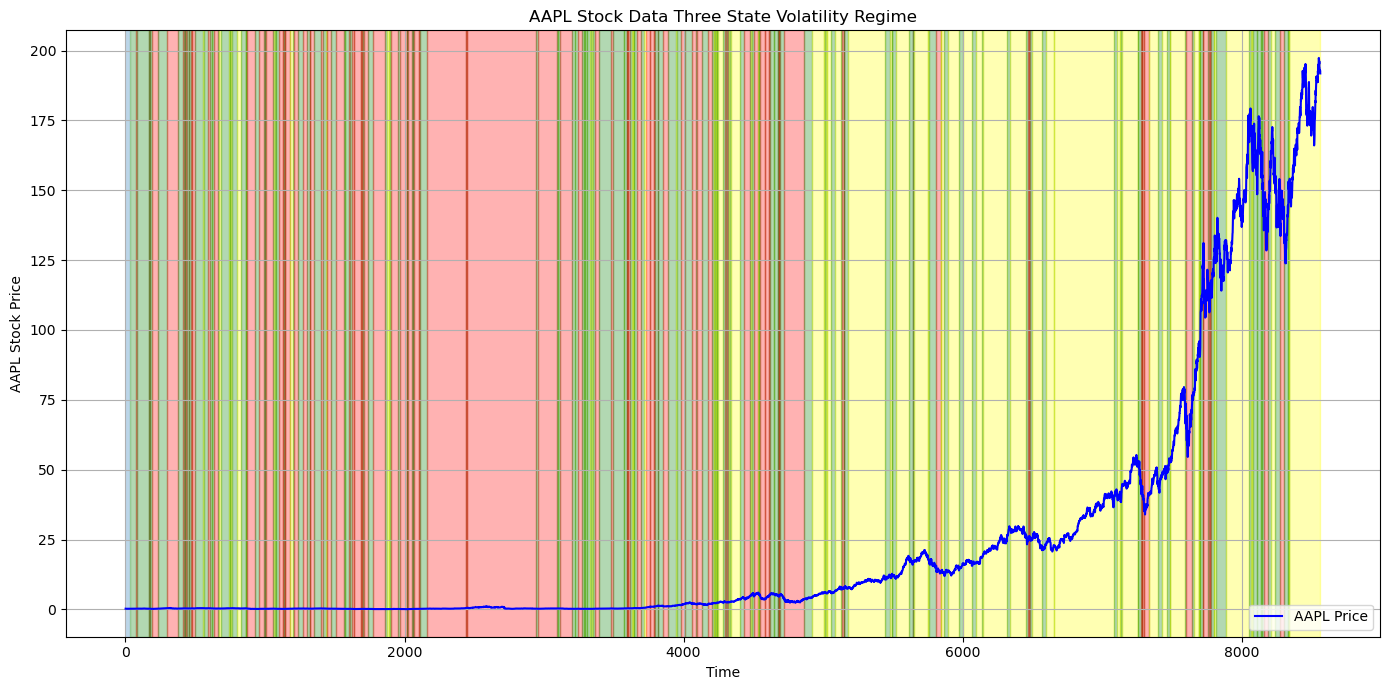

In [30]:
### Plot Three State Volatities
def plot_three_state(data):
    # Prepare the plot
    plt.figure(figsize = (14, 7))
    plt.plot(data.index, data['AAPL'], label = 'AAPL Price', color = 'blue')  # Assuming 'AAPL' is the correct column name

    # Create shaded areas based on the regime
    start = data.index[0]
    current_regime = data['Regime'].iloc[0]
    
    for i in range(1, len(data)):
        if data['Regime'].iloc[i] != current_regime:
            end = data.index[i]
            plt.axvspan(start, end, color = get_color(current_regime), alpha = 0.3)
            start = end
            current_regime = data['Regime'].iloc[i]
    
    # Cover the last segment
    plt.axvspan(start, data.index[-1], color = get_color(current_regime), alpha = 0.3)
    
    # Add legend and labels
    plt.title('AAPL Stock Data Three State Volatility Regime')
    plt.xlabel('Time')
    plt.ylabel('AAPL Stock Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    plt.show()

### Function to Determine Color Scheme
def get_color(regime):
    if regime == 'High':
        return 'red'  # Correct color name
    elif regime == 'Medium':
        return 'green'  # Correct color name
    elif regime == 'Low':
        return 'yellow'  # Correct color name

### Display Plot
plot_three_state(stock_data_full)


In [79]:
### Build and Populate Transition Matrix
def build_transition_matrix(data, regimes, window):
    ## Construct matrix of zeros
    transition_matrix = pd.DataFrame(0, index = regimes, columns = regimes, dtype = float)
    
    ## Iterate through regimes in data and populate matrix
    # Remove rows where 'Regime' is NaN
    cleaned_data = data.dropna(subset = ['Regime'])
    # Iterate over the length of the df to categorize data
    for i in range(len(cleaned_data) - 1):
        current_regime = cleaned_data['Regime'].iloc[i]
        #print(current_regime)
        next_regime = cleaned_data['Regime'].iloc[i + 1]
        #print(next_regime)
        transition_matrix.loc[current_regime, next_regime] += 1

    ## Normalize the rows if the matrix
    # Sum the rows and divide by the summed value
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis = 1), axis = 0).fillna(0)

    return transition_matrix

regimes = ['Low', 'Medium', 'High']
transition_matrix = build_transition_matrix(stock_data_full, regimes, window = 30)
print(transition_matrix)


             Low    Medium      High
Low     0.969815  0.029830  0.000355
Medium  0.030185  0.937855  0.031960
High    0.000345  0.031013  0.968642
